In [87]:
import pandas as pd

In [88]:
pip install yfinance

In [89]:
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import time

In [90]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into string
    processed_text = ' '.join(tokens)

    return processed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Initialize SentimentIntensityAnalyzer from NLTK
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    scores = sid.polarity_scores(text)
    return scores['compound']  # Use compound score as overall sentiment


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [92]:
def extract_articles_from_page(page_number):
    url = f"https://www.ft.com/search?q=Apple+Inc.&page={page_number}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    for article in soup.find_all('div', class_='o-teaser'):
        title_tag = article.find('a', class_='js-teaser-heading-link')
        date_tag = article.find('time', class_='o-teaser__timestamp-date')

        if title_tag and date_tag:
            title = title_tag.get_text(strip=True)
            date = date_tag.get_text(strip=True)
            articles.append((date, title))

    return articles

# Main scraping loop
all_articles = []
for page in range(1, 51):  # Scraping first 50 pages
    articles = extract_articles_from_page(page)
    all_articles.extend(articles)
    time.sleep(1)  # Be nice to the server and avoid sending too many requests in a short time


In [93]:


# Convert articles list to DataFrame
articles_df = pd.DataFrame(all_articles, columns=['Date', 'Title'])

# Convert 'Date' column to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Date'])

# Preprocess the article titles
# articles_df['Title'] = articles_df['Title'].apply(preprocess_text)

# Group by date and concatenate titles
grouped_articles = articles_df.groupby('Date')['Title'].apply(' || '.join).reset_index()


# Fetch stock data for the relevant dates
start_date = grouped_articles['Date'].min().strftime('%Y-%m-%d')
end_date = grouped_articles['Date'].max().strftime('%Y-%m-%d')
stock_data = yf.download('AAPL', start=start_date, end=end_date)

# Reset index to have date as a column
stock_data.reset_index(inplace=True)

# Keep only relevant columns
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert 'Date' column in stock_data to datetime to match grouped_articles
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge grouped articles with stock data on the date
merged_data = pd.merge(grouped_articles, stock_data, how='left', on='Date')
merged_data['Title_Processed'] = merged_data['Title'].apply(preprocess_text)
# Apply sentiment analysis to each title
merged_data['Sentiment'] = merged_data['Title_Processed'].apply(get_sentiment_scores)
# Forward fill to handle missing stock prices for weekends/holidays
merged_data = merged_data.ffill()

# Create the label column
merged_data['Label'] = merged_data['Close'].diff().apply(
    lambda x: 1 if x > 0 else 0
)

# Sort by date
merged_data = merged_data.sort_values(by='Date')

[*********************100%%**********************]  1 of 1 completed
<ipython-input-93-3e9996009ca4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


In [94]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features

# Fit and transform the processed titles
title_tfidf = tfidf_vectorizer.fit_transform(merged_data['Title_Processed'])

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust n_components as needed

# Fit LDA model
topics = lda.fit_transform(title_tfidf)

# Add topic proportions to merged_data
for idx, topic in enumerate(topics.T):
    merged_data[f'Topic_{idx+1}'] = topic


In [95]:
merged_data

,Date,Title,Open,High,Low,Close,Title_Processed,Sentiment,Label,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,2020-11-12,Applechips away at a new strategy for computing,119.620003,120.529999,118.570000,119.209999,applechips away new strategy computing,0.0000,0,0.033681,0.033680,0.033681,0.033682,0.033680,0.033680,0.033679,0.696876,0.033680,0.033679
1,2020-11-18,Applehalving splits opinion || Appleto halve A...,118.610001,119.820000,118.000000,118.029999,applehalving split opinion appleto halve app s...,0.0000,0,0.027697,0.027701,0.027702,0.027699,0.027697,0.027698,0.027696,0.750707,0.027695,0.027707
2,2020-12-01,Applesued in Europe over software update that ...,121.010002,123.470001,120.010002,122.720001,applesued europe software update slowed old ip...,0.0000,1,0.030983,0.030992,0.030986,0.030985,0.030983,0.030994,0.721124,0.030985,0.030985,0.030983
3,2020-12-18,ApplePay draws antitrust attention || Cyberpun...,128.960007,129.100006,126.120003,126.660004,applepay draw antitrust attention cyberpunk ’ ...,-0.4767,1,0.033490,0.033489,0.033488,0.033488,0.033488,0.033488,0.033488,0.033490,0.698603,0.033488
4,2020-12-22,Cook turned back on Musk offer to sell Tesla t...,131.610001,134.410004,129.649994,131.880005,cook turned back musk offer sell tesla toapple,0.0000,1,0.762565,0.026384,0.026375,0.026374,0.026375,0.026419,0.026376,0.026378,0.026374,0.026379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2024-06-13,"Hey Siri, is Apple’s AI strategy enough to sus...",214.740005,216.750000,211.600006,214.240005,hey siri apple ’ ai strategy enough sustain ra...,0.0000,1,0.021973,0.021975,0.021977,0.021970,0.021970,0.021970,0.021972,0.802249,0.021975,0.021970
607,2024-06-14,Appleset to be first Big Tech group to face ch...,213.850006,215.169998,211.300003,212.490005,appleset first big tech group face charge eu d...,0.5267,0,0.020838,0.020827,0.020837,0.020834,0.020825,0.020831,0.020828,0.020830,0.020831,0.812519
608,2024-06-17,"Applescraps ‘buy now, pay later’ service in US...",213.369995,218.949997,212.720001,216.669998,applescraps ‘ buy pay later ’ service u month ...,-0.1027,1,0.029223,0.029222,0.029222,0.435174,0.029222,0.029226,0.029241,0.029228,0.331015,0.029227
609,2024-06-18,Appleto settle ‘tap-and-go’ payments probe wit...,217.589996,218.630005,213.000000,214.289993,appleto settle ‘ tapandgo ’ payment probe eu f...,-0.4215,0,0.392644,0.026480,0.395522,0.026479,0.026477,0.026477,0.026477,0.026482,0.026480,0.026483


In [96]:
from sklearn.model_selection import train_test_split

# Define feature columns and target variable
features = merged_data.drop(columns=['Date', 'Title', 'Title_Processed', 'Label'])
target = merged_data['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [97]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data, and transform the testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [98]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [99]:
from sklearn.svm import SVC

# Initialize and train SVM model
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)


SVC()

In [100]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier()

In [101]:
from sklearn.neural_network import MLPClassifier

# Initialize and train Neural Network model
nn_model = MLPClassifier(max_iter=1000)
nn_model.fit(X_train_scaled, y_train)


MLPClassifier(max_iter=1000)

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate Logistic Regression
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test)
print(f'Logistic Regression: Accuracy={lr_metrics[0]}, Precision={lr_metrics[1]}, Recall={lr_metrics[2]}, F1 Score={lr_metrics[3]}')

# Evaluate SVM
svm_metrics = evaluate_model(svm_model, X_test_scaled, y_test)
print(f'SVM: Accuracy={svm_metrics[0]}, Precision={svm_metrics[1]}, Recall={svm_metrics[2]}, F1 Score={svm_metrics[3]}')

# Evaluate Random Forest
rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test)
print(f'Random Forest: Accuracy={rf_metrics[0]}, Precision={rf_metrics[1]}, Recall={rf_metrics[2]}, F1 Score={rf_metrics[3]}')

# Evaluate Neural Network
nn_metrics = evaluate_model(nn_model, X_test_scaled, y_test)
print(f'Neural Network: Accuracy={nn_metrics[0]}, Precision={nn_metrics[1]}, Recall={nn_metrics[2]}, F1 Score={nn_metrics[3]}')


Logistic Regression: Accuracy=0.6016260162601627, Precision=0.6363636363636364, Recall=0.3620689655172414, F1 Score=0.4615384615384615
SVM: Accuracy=0.5203252032520326, Precision=0.4857142857142857, Recall=0.29310344827586204, F1 Score=0.3655913978494624
Random Forest: Accuracy=0.42276422764227645, Precision=0.3488372093023256, Recall=0.25862068965517243, F1 Score=0.297029702970297
Neural Network: Accuracy=0.6341463414634146, Precision=0.6065573770491803, Recall=0.6379310344827587, F1 Score=0.6218487394957983


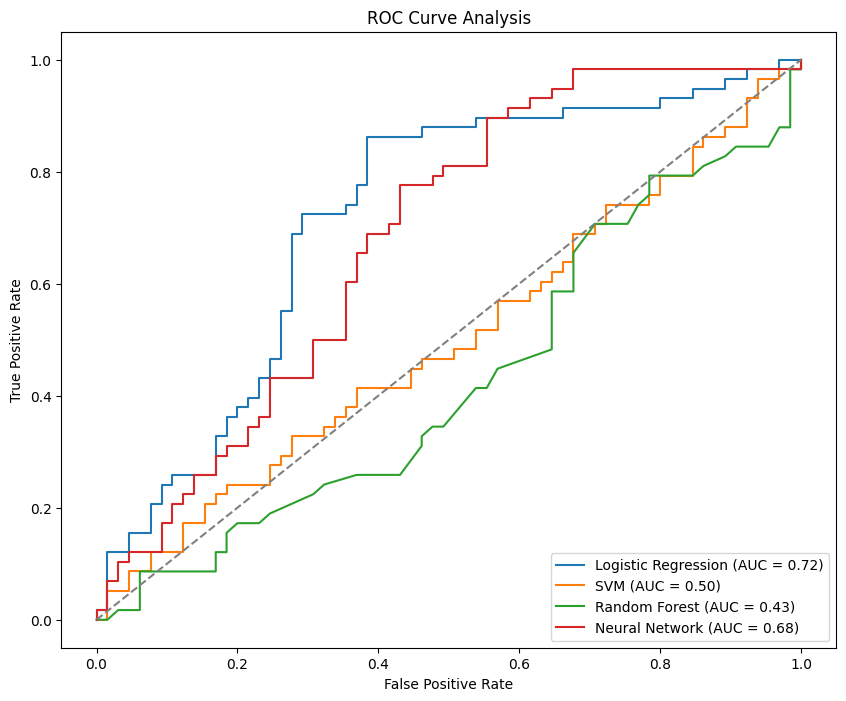

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
svm_probs = svm_model.decision_function(X_test_scaled)  # For SVM, use decision_function
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
nn_probs = nn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

# Calculate AUC scores
lr_auc = auc(lr_fpr, lr_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
nn_auc = auc(nn_fpr, nn_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')

# Show plot
plt.show()


In [104]:
model_accuracies = {
    'Logistic Regression': lr_metrics[0],
    'SVM': svm_metrics[0],
    'Random Forest': rf_metrics[0],
    'Neural Network': nn_metrics[0]
}

# Find the model with the highest accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]

# Print the best model and its accuracy
print(f'The best model is {best_model_name} with an accuracy of {best_accuracy}')

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'SVM':
    best_model = svm_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Neural Network':
    best_model = nn_model

The best model is Neural Network with an accuracy of 0.6341463414634146


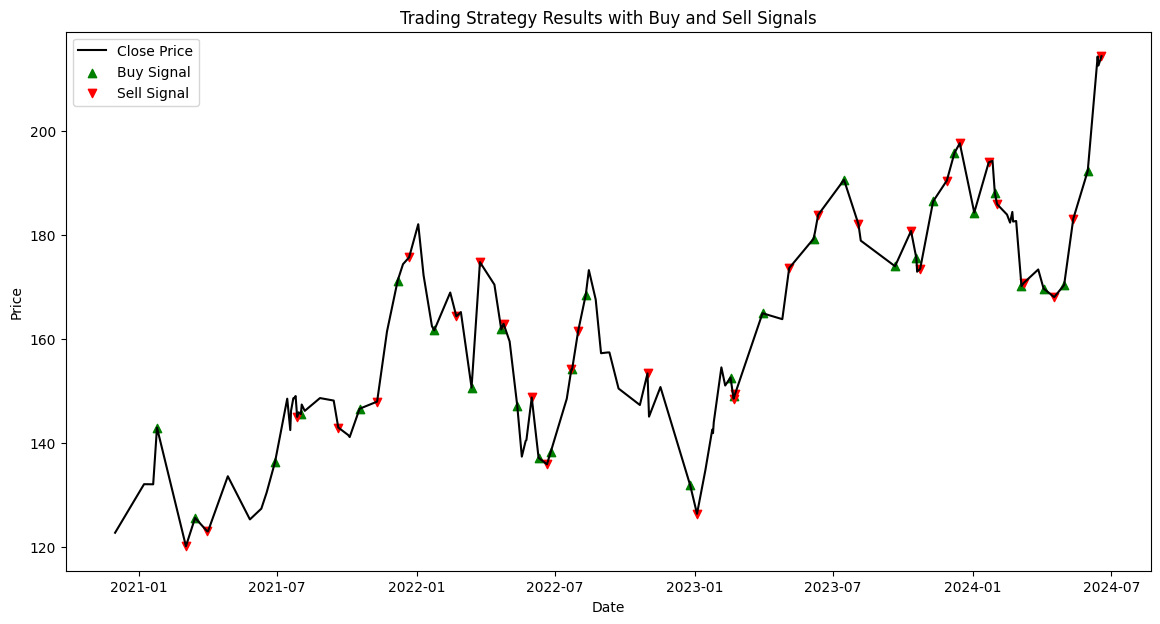

Final Portfolio Value: $10702.70
Sharpe Ratio: 1.87
Maximum Drawdown: 2.88%
Number of Trades Executed: 60
Win Ratio: 63.33%


In [105]:
predicted = best_model.predict(X_test_scaled)
test_data = merged_data.iloc[X_test.index].copy()
test_data.sort_values('Date',inplace=True)
test_data.reset_index(drop=True,inplace=True)

test_data['Predicted'] = predicted

# Calculate signal based on Predicted column
test_data['Signal'] = test_data['Predicted'].diff()

# Initialize position column and portfolio variables
initial_capital = 10000
share_size = 10
transaction_cost = 0  # Transaction cost per trade
portfolio_value = initial_capital
holdings = 0
position_open = False
portfolio = []

# Initialize buy and sell signals lists
buy_signals = []
sell_signals = []

for index, row in test_data.iterrows():
    if row['Signal'] == 1 and not position_open:  # Buy signal and no open position
        holdings += share_size
        portfolio_value -= row['Close'] * share_size + transaction_cost
        position_open = True
        buy_signals.append((row['Date'], row['Close']))
    elif row['Signal'] == -1 and position_open:  # Sell signal and open position
        portfolio_value += row['Close'] * share_size - transaction_cost
        holdings -= share_size
        position_open = False
        sell_signals.append((row['Date'], row['Close']))
    portfolio.append(portfolio_value + holdings * row['Close'])

# Add portfolio value to DataFrame
test_data['Portfolio'] = portfolio

# Plot results with buy and sell signals

plt.figure(figsize=(14, 7))

plt.plot(test_data['Date'], test_data['Close'], label='Close Price',color='black', alpha=1)
plt.scatter(*zip(*buy_signals), label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(*zip(*sell_signals), label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Trading Strategy Results with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate performance metrics
returns = pd.Series(portfolio).pct_change().dropna()
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe Ratio
drawdown = 1 - (pd.Series(portfolio) / pd.Series(portfolio).cummax())
max_drawdown = drawdown.max()
num_trades = len(buy_signals) + len(sell_signals)
win_ratio = ((test_data['Signal'] == 1) & (test_data['Close'].shift(-1) > test_data['Close'])).sum() / len(test_data[test_data['Signal'] == 1])

final_portfolio_value = portfolio[-1]

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")

In [106]:
def extract_articles_from_page(page_number):
    url = f"https://www.ft.com/search?q=google&page={page_number}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    for article in soup.find_all('div', class_='o-teaser'):
        title_tag = article.find('a', class_='js-teaser-heading-link')
        date_tag = article.find('time', class_='o-teaser__timestamp-date')

        if title_tag and date_tag:
            title = title_tag.get_text(strip=True)
            date = date_tag.get_text(strip=True)
            articles.append((date, title))

    return articles

# Main scraping loop
all_articles = []
for page in range(1, 51):  # Scraping first 50 pages
    articles = extract_articles_from_page(page)
    all_articles.extend(articles)
    time.sleep(1)  # Be nice to the server and avoid sending too many requests in a short time


In [107]:


# Convert articles list to DataFrame
articles_df = pd.DataFrame(all_articles, columns=['Date', 'Title'])

# Convert 'Date' column to datetime
articles_df['Date'] = pd.to_datetime(articles_df['Date'])

# Preprocess the article titles
# articles_df['Title'] = articles_df['Title'].apply(preprocess_text)

# Group by date and concatenate titles
grouped_articles = articles_df.groupby('Date')['Title'].apply(' || '.join).reset_index()


# Fetch stock data for the relevant dates
start_date = grouped_articles['Date'].min().strftime('%Y-%m-%d')
end_date = grouped_articles['Date'].max().strftime('%Y-%m-%d')
stock_data = yf.download('GOOGL', start=start_date, end=end_date)

# Reset index to have date as a column
stock_data.reset_index(inplace=True)

# Keep only relevant columns
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert 'Date' column in stock_data to datetime to match grouped_articles
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge grouped articles with stock data on the date
merged_data = pd.merge(grouped_articles, stock_data, how='left', on='Date')
merged_data['Title_Processed'] = merged_data['Title'].apply(preprocess_text)
# Apply sentiment analysis to each title
merged_data['Sentiment'] = merged_data['Title_Processed'].apply(get_sentiment_scores)
# Forward fill to handle missing stock prices for weekends/holidays
merged_data = merged_data.ffill()

# Create the label column
merged_data['Label'] = merged_data['Close'].diff().apply(
    lambda x: 1 if x > 0 else 0
)

# Sort by date
merged_data = merged_data.sort_values(by='Date')

[*********************100%%**********************]  1 of 1 completed
<ipython-input-107-8d918e3c96f3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


In [108]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features

# Fit and transform the processed titles
title_tfidf = tfidf_vectorizer.fit_transform(merged_data['Title_Processed'])

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust n_components as needed

# Fit LDA model
topics = lda.fit_transform(title_tfidf)

# Add topic proportions to merged_data
for idx, topic in enumerate(topics.T):
    merged_data[f'Topic_{idx+1}'] = topic


In [109]:
merged_data

,Date,Title,Open,High,Low,Close,Title_Processed,Sentiment,Label,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,2023-01-03,Googledevelops free terrorism moderation tool ...,89.589996,91.050003,88.519997,89.120003,googledevelops free terrorism moderation tool ...,-0.3182,0,0.030971,0.030971,0.721256,0.030971,0.030971,0.030971,0.030973,0.030972,0.030973,0.030971
1,2023-01-04,India rejects Google’s request to block $160mn...,90.349998,90.650002,87.269997,88.080002,india reject google ’ request block 160mn anti...,-0.7096,0,0.757443,0.026950,0.026951,0.026950,0.026950,0.026950,0.026950,0.026952,0.026950,0.026955
2,2023-01-06,Whatever happened toGoogleSearch?,86.790001,87.690002,84.860001,87.339996,whatever happened togooglesearch,0.0000,0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,2023-01-11,Microsoft: AI will not turn Bing into aGoogle-...,89.180000,91.599998,89.010002,91.519997,microsoft ai turn bing agooglekiller letter fo...,0.3612,1,0.026924,0.026923,0.026921,0.757704,0.026921,0.026922,0.026921,0.026923,0.026921,0.026920
4,2023-01-19,GoogleTranslate for the zoo? How humans might ...,90.720001,93.610001,90.629997,93.050003,googletranslate zoo human might talk animal,0.0000,1,0.033399,0.033398,0.033399,0.033405,0.033398,0.033399,0.033398,0.699405,0.033400,0.033398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2024-06-15,"After Baillie Gifford, who is ‘clean’ enough t...",174.220001,177.059998,174.149994,176.789993,baillie gifford ‘ clean ’ enough fund art,0.4019,0,0.738758,0.029028,0.029025,0.029026,0.029026,0.029026,0.029027,0.029029,0.029027,0.029027
320,2024-06-17,India pulls in tech giants for its AI ambition...,175.460007,178.360001,174.809998,177.240005,india pull tech giant ai ambition bullish case...,0.0000,1,0.028548,0.028546,0.028547,0.028547,0.028546,0.028546,0.028547,0.028546,0.028552,0.743075
321,2024-06-18,Transcript: Mr OpenAI goes to Washington || El...,177.139999,177.389999,174.100006,175.089996,transcript mr openai go washington electriccar...,0.4767,0,0.021110,0.021110,0.021111,0.809989,0.021108,0.021115,0.021111,0.021110,0.021123,0.021113
322,2024-06-19,Silicon Valley steps up staff screening over C...,177.139999,177.389999,174.100006,175.089996,silicon valley step staff screening chinese es...,-0.7184,0,0.017869,0.017870,0.017870,0.017879,0.017872,0.017878,0.017874,0.017865,0.839152,0.017870


In [110]:
from sklearn.model_selection import train_test_split

# Define feature columns and target variable
features = merged_data.drop(columns=['Date', 'Title', 'Title_Processed', 'Label'])
target = merged_data['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [111]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()
test2=X_test
# Fit and transform the training data, and transform the testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [112]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [113]:
from sklearn.svm import SVC

# Initialize and train SVM model
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)


SVC()

In [114]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier()

In [115]:
from sklearn.neural_network import MLPClassifier

# Initialize and train Neural Network model
nn_model = MLPClassifier(max_iter=1000)
nn_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=1000)

In [116]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate Logistic Regression
lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test)
print(f'Logistic Regression: Accuracy={lr_metrics[0]}, Precision={lr_metrics[1]}, Recall={lr_metrics[2]}, F1 Score={lr_metrics[3]}')

# Evaluate SVM
svm_metrics = evaluate_model(svm_model, X_test_scaled, y_test)
print(f'SVM: Accuracy={svm_metrics[0]}, Precision={svm_metrics[1]}, Recall={svm_metrics[2]}, F1 Score={svm_metrics[3]}')

# Evaluate Random Forest
rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test)
print(f'Random Forest: Accuracy={rf_metrics[0]}, Precision={rf_metrics[1]}, Recall={rf_metrics[2]}, F1 Score={rf_metrics[3]}')

# Evaluate Neural Network
nn_metrics = evaluate_model(nn_model, X_test_scaled, y_test)
print(f'Neural Network: Accuracy={nn_metrics[0]}, Precision={nn_metrics[1]}, Recall={nn_metrics[2]}, F1 Score={nn_metrics[3]}')


Logistic Regression: Accuracy=0.6461538461538462, Precision=0.59375, Recall=0.6551724137931034, F1 Score=0.6229508196721311
SVM: Accuracy=0.47692307692307695, Precision=0.41379310344827586, Recall=0.41379310344827586, F1 Score=0.41379310344827586
Random Forest: Accuracy=0.6307692307692307, Precision=0.5806451612903226, Recall=0.6206896551724138, F1 Score=0.6000000000000001
Neural Network: Accuracy=0.6461538461538462, Precision=0.59375, Recall=0.6551724137931034, F1 Score=0.6229508196721311


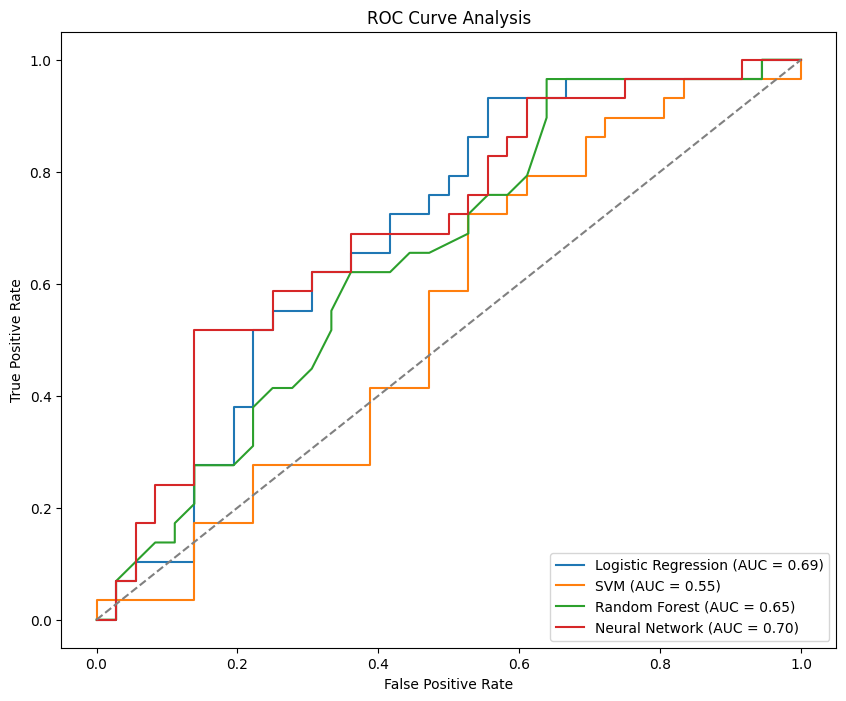

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
svm_probs = svm_model.decision_function(X_test_scaled)  # For SVM, use decision_function
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
nn_probs = nn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

# Calculate AUC scores
lr_auc = auc(lr_fpr, lr_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
nn_auc = auc(nn_fpr, nn_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')

# Show plot
plt.show()


In [118]:
model_accuracies = {
    'Logistic Regression': lr_metrics[0],
    'SVM': svm_metrics[0],
    'Random Forest': rf_metrics[0],
    'Neural Network': nn_metrics[0]
}

# Find the model with the highest accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]

# Print the best model and its accuracy
print(f'The best model is {best_model_name} with an accuracy of {best_accuracy}')

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'SVM':
    best_model = svm_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Neural Network':
    best_model = nn_model

The best model is Logistic Regression with an accuracy of 0.6461538461538462


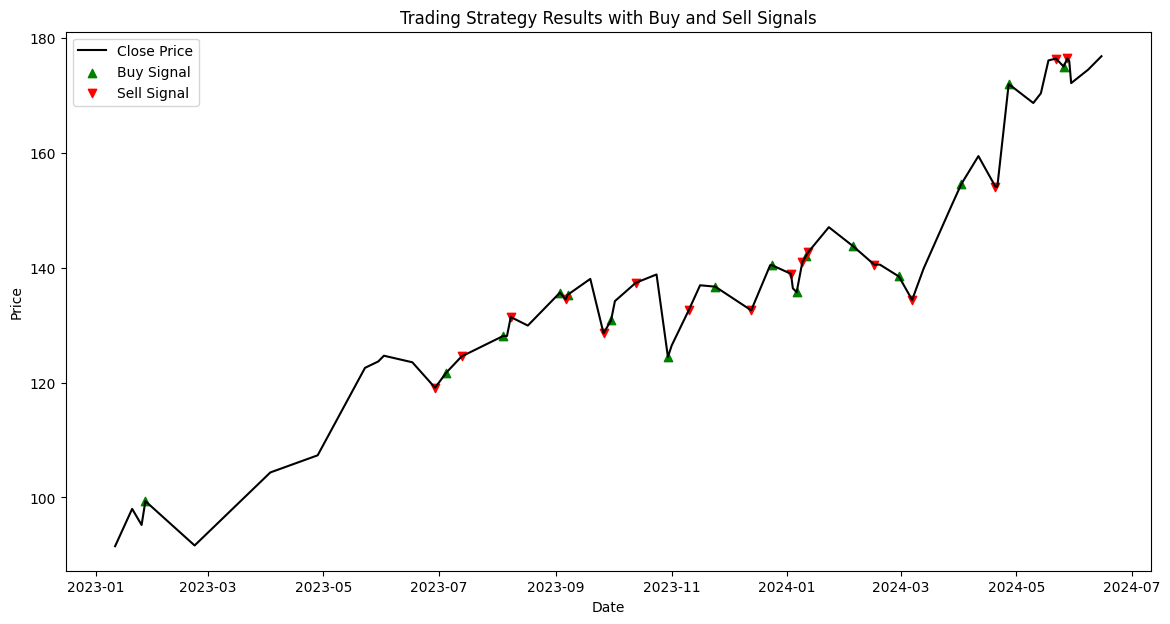

Final Portfolio Value: $10308.50
Sharpe Ratio: 2.16
Maximum Drawdown: 1.07%
Number of Trades Executed: 32
Win Ratio: 50.00%


In [119]:
predicted = best_model.predict(X_test_scaled)
test_data = merged_data.iloc[X_test.index].copy()
test_data.sort_values('Date',inplace=True)
test_data.reset_index(drop=True,inplace=True)

test_data['Predicted'] = predicted

# Calculate signal based on Predicted column
test_data['Signal'] = test_data['Predicted'].diff()

# Initialize position column and portfolio variables
initial_capital = 10000
share_size = 10
transaction_cost = 0  # Transaction cost per trade
portfolio_value = initial_capital
holdings = 0
position_open = False
portfolio = []

# Initialize buy and sell signals lists
buy_signals = []
sell_signals = []

for index, row in test_data.iterrows():
    if row['Signal'] == 1 and not position_open:  # Buy signal and no open position
        holdings += share_size
        portfolio_value -= row['Close'] * share_size + transaction_cost
        position_open = True
        buy_signals.append((row['Date'], row['Close']))
    elif row['Signal'] == -1 and position_open:  # Sell signal and open position
        portfolio_value += row['Close'] * share_size - transaction_cost
        holdings -= share_size
        position_open = False
        sell_signals.append((row['Date'], row['Close']))
    portfolio.append(portfolio_value + holdings * row['Close'])

# Add portfolio value to DataFrame
test_data['Portfolio'] = portfolio

# Plot results with buy and sell signals

plt.figure(figsize=(14, 7))

plt.plot(test_data['Date'], test_data['Close'], label='Close Price',color='black', alpha=1)
plt.scatter(*zip(*buy_signals), label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(*zip(*sell_signals), label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Trading Strategy Results with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate performance metrics
returns = pd.Series(portfolio).pct_change().dropna()
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe Ratio
drawdown = 1 - (pd.Series(portfolio) / pd.Series(portfolio).cummax())
max_drawdown = drawdown.max()
num_trades = len(buy_signals) + len(sell_signals)
win_ratio = ((test_data['Signal'] == 1) & (test_data['Close'].shift(-1) > test_data['Close'])).sum() / len(test_data[test_data['Signal'] == 1])

final_portfolio_value = portfolio[-1]

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")